# Lab 1 Bode Plot
---

Generate a bode magnitude and phase plot for the wave data collected.

---

In [1441]:
import pandas as pd
import matplotlib as plt
import numpy as np

In [1442]:
df = pd.read_csv('test2.csv', index_col=False, skiprows=4, delimiter='\t',
                names=['time_s', 'cmd_sig', 'ang_deg', 'vel', 'amp', 'freq_hz',
                         'sin0_or_sqr1'])
df.head()

,time_s,cmd_sig,ang_deg,vel,amp,freq_hz,sin0_or_sqr1
0,10.383094,-41.967187,2354.287257,0.200384,350.0,0.05,0.0
1,10.383594,-42.021779,2354.287257,0.200242,350.0,0.05,0.0
2,10.384094,-42.076369,2354.287257,0.200225,350.0,0.05,0.0
3,10.384594,-42.130959,2354.287257,0.200214,350.0,0.05,0.0
4,10.385094,-42.185537,2354.287257,0.200196,350.0,0.05,0.0


In [1443]:
type(df["ang_deg"].to_numpy())

numpy.ndarray

In [1444]:
df.insert(3, "ang_rad", df["ang_deg"].to_numpy()*np.pi/180, True)
df.insert(7, 'freq_rad', df['freq_hz'].to_numpy()*2*np.pi, True)
df.insert(5, 'vel_rad', df['vel'].to_numpy()*2*np.pi, True)
df.insert(2, 'cmd_volts', df['cmd_sig'].to_numpy()*9/1080)
df.head()


,time_s,cmd_sig,cmd_volts,ang_deg,ang_rad,vel,vel_rad,amp,freq_hz,freq_rad,sin0_or_sqr1
0,10.383094,-41.967187,-0.349727,2354.287257,41.090064,0.200384,1.259050,350.0,0.05,0.314159,0.0
1,10.383594,-42.021779,-0.350181,2354.287257,41.090064,0.200242,1.258158,350.0,0.05,0.314159,0.0
2,10.384094,-42.076369,-0.350636,2354.287257,41.090064,0.200225,1.258051,350.0,0.05,0.314159,0.0
3,10.384594,-42.130959,-0.351091,2354.287257,41.090064,0.200214,1.257982,350.0,0.05,0.314159,0.0
4,10.385094,-42.185537,-0.351546,2354.287257,41.090064,0.200196,1.257869,350.0,0.05,0.314159,0.0


<Axes: xlabel='time_s'>

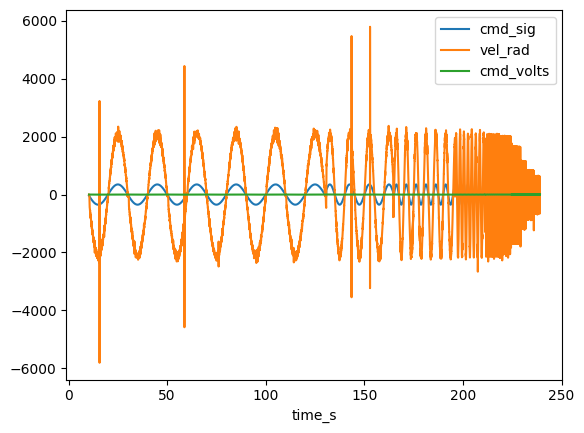

In [1445]:
df.plot(x="time_s", y=["cmd_sig", "vel_rad", 'cmd_volts'])

In [1446]:
frequencies = df['freq_hz'].unique().tolist()
print(frequencies)
frequency = frequencies[7]
frequency_rad = frequency*2*np.pi

[0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0, 15.0, 20.0]


<Axes: xlabel='time_s'>

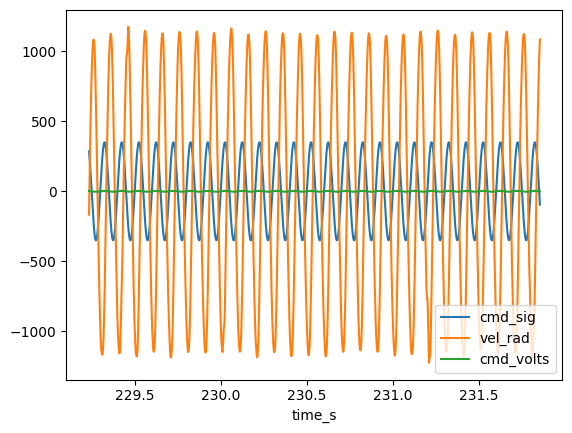

In [1447]:
freq_0p05 = df[df['freq_hz'] == frequency]
freq_0p05 = freq_0p05.drop(freq_0p05.index[-150:0])
freq_0p05 = freq_0p05.drop(freq_0p05.index[0:150])
freq_0p05.plot(x="time_s", y=["cmd_sig", "vel_rad", 'cmd_volts'])

<Axes: xlabel='time_s'>

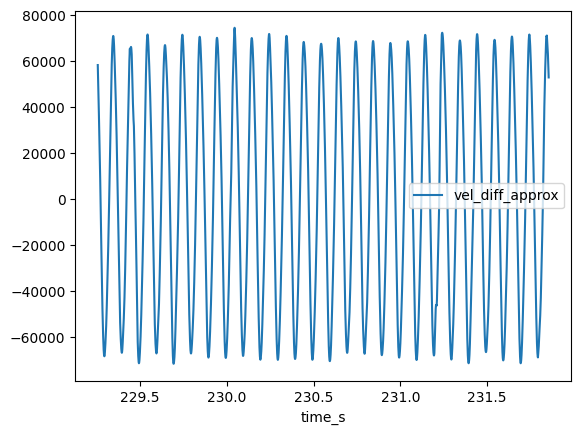

In [1448]:
freq_0p05.insert(5, 'vel_diff_approx', freq_0p05['vel_rad'].diff(40)/freq_0p05['time_s'].diff(40), True)
freq_0p05.plot(x="time_s", y="vel_diff_approx")
#freq_0p05.at[10,'vel_diff_approx']

In [1449]:
# Outlier Filtering
'''
outliers = freq_0p05[abs(freq_0p05['vel_diff_approx']) > 2e4].index
freq_0p05 = freq_0p05.drop(outliers)
freq_0p05.plot(x='time_s', y='vel_diff_approx')
'''

"\noutliers = freq_0p05[abs(freq_0p05['vel_diff_approx']) > 2e4].index\nfreq_0p05 = freq_0p05.drop(outliers)\nfreq_0p05.plot(x='time_s', y='vel_diff_approx')\n"

<Axes: xlabel='time_s'>

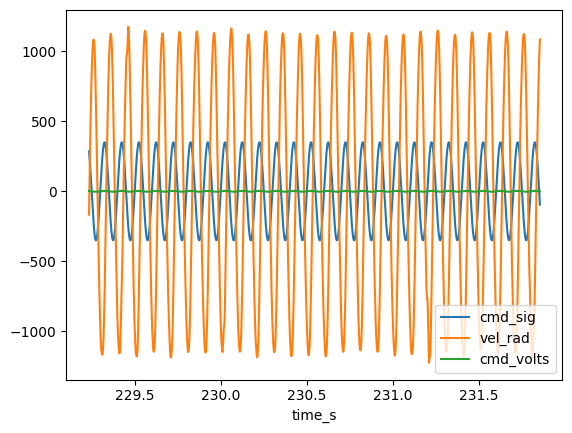

In [1450]:
freq_0p05.plot(x="time_s", y=["cmd_sig", "vel_rad", 'cmd_volts'])

In [1451]:
freq_0p05.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5225 entries, 436484 to 441708
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time_s           5225 non-null   float64
 1   cmd_sig          5225 non-null   float64
 2   cmd_volts        5225 non-null   float64
 3   ang_deg          5225 non-null   float64
 4   ang_rad          5225 non-null   float64
 5   vel_diff_approx  5185 non-null   float64
 6   vel              5225 non-null   float64
 7   vel_rad          5225 non-null   float64
 8   amp              5225 non-null   float64
 9   freq_hz          5225 non-null   float64
 10  freq_rad         5225 non-null   float64
 11  sin0_or_sqr1     5225 non-null   float64
dtypes: float64(12)
memory usage: 530.7 KB


---

## Fit function to data using LLSQ

In [1452]:
from scipy.optimize import leastsq

In [1453]:
def sin_fit(time, freq, guess_mean, guess_phase, guess_amp, data):
    optimize_func = lambda x: x[0]*np.sin(freq*time+x[1]) + x[2] - data
    return leastsq(optimize_func, [guess_amp, guess_phase, guess_mean])[0]

[-1153.82779053   -80.75294018   -11.17484437]


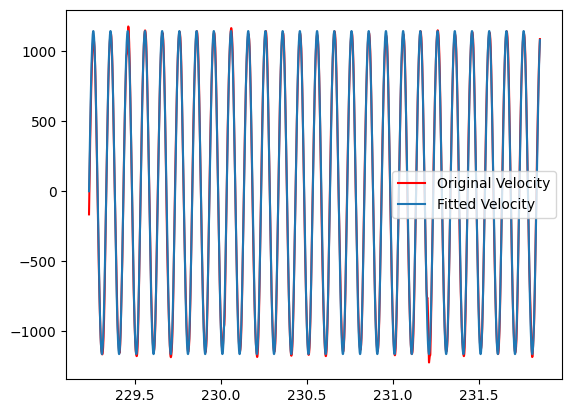

In [1454]:
time = freq_0p05['time_s'].to_numpy()
freq = frequency_rad
data = freq_0p05['vel_rad'].to_numpy()
coef_vel_fit = sin_fit(time, freq, 0, 0, 1, data)
vel_fit = coef_vel_fit[0]*np.sin(freq*time+coef_vel_fit[1])+coef_vel_fit[2]
print(coef_vel_fit)

plt.pyplot.plot(freq_0p05['time_s'], freq_0p05['vel_rad'], "r", freq_0p05['time_s'], vel_fit)
plt.pyplot.legend(['Original Velocity', 'Fitted Velocity'])

[ 2.91659937e+00 -3.15315745e-02 -1.22298817e-04]


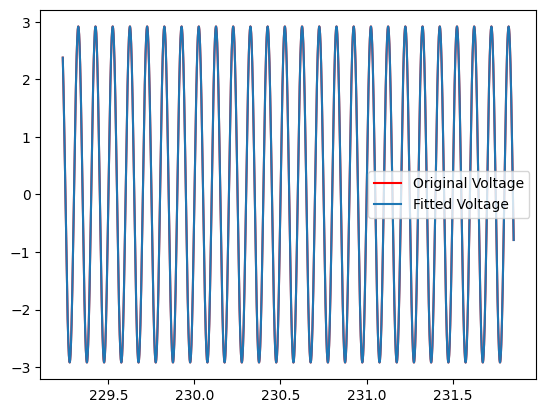

In [1455]:
data = freq_0p05['cmd_volts'].to_numpy()
coef_cmd_volt_fit = sin_fit(time, freq, 0, 0, 1, data)
cmd_volt_fit = coef_cmd_volt_fit[0]*np.sin(freq*time+coef_cmd_volt_fit[1])+coef_cmd_volt_fit[2]
print(coef_cmd_volt_fit)

plt.pyplot.plot(freq_0p05['time_s'], freq_0p05['cmd_volts'], "r", freq_0p05['time_s'], cmd_volt_fit)
plt.pyplot.legend(['Original Voltage', 'Fitted Voltage'])

---

In [1456]:
phase_shift = np.rad2deg(coef_vel_fit[1] - coef_cmd_volt_fit[1])
magnitude = 20*np.log10(abs(coef_vel_fit[0]/coef_cmd_volt_fit[0]))
print(phase_shift, magnitude)
phase_shift

-4624.996029643068 51.94528434178784


-4624.996029643068

0.05 -> -1.410869679896649, 57.35350168000396

0.1 -> -2.0557081782149544, 57.42573787745617

0.2 -> -3.5417511324306683 57.428257577483855

0.5 -> -728.4205341696356 57.39744977111711

1.0 -> -1816.706834813962 57.31901981480584

2.0 -> -1834.3567832549127 56.93962488289152 or -391.9541224705125 57.061762903888855

5.0 -> -5471.755094382316 55.38587915860894

10.0 -> -4624.996029643068 51.94528434178784

15.0 -> -710.0512720132494 48.992583935838994

20 -> -327.58453340373075 46.40142882492539

In [1457]:
phase = [-1.410869679896649, -2.0557081782149544, -3.5417511324306683, -728.4205341696356,
          -1816.706834813962, -1834.3567832549127, -5471.755094382316, -4624.996029643068, -710.0512720132494, -327.58453340373075]
phase1 = [p + abs(np.floor(abs(p/360))*360) if abs(p) > 360 else p for p in phase]
print(phase1)
mag = [57.35350168000396, 57.42573787745617, 57.428257577483855, 57.39744977111711, 57.31901981480584,
       56.93962488289152, 55.38587915860894, 51.94528434178784, 48.992583935838994, 46.40142882492539]
frequencies_rad = np.deg2rad(frequencies)
frequencies_rad

[-1.410869679896649, -2.0557081782149544, -3.5417511324306683, -8.42053416963563, -16.706834813961905, -34.35678325491267, -71.7550943823162, -304.99602964306814, -350.05127201324945, -327.58453340373075]


array([0.00087266, 0.00174533, 0.00349066, 0.00872665, 0.01745329,
       0.03490659, 0.08726646, 0.17453293, 0.26179939, 0.34906585])

'\nplt.pyplot.xscale(\'log\')\nplt.pyplot.grid(True, which="both", ls="--")\nax[0].plot(frequencies_rad, mag)\nplt.pyplot.xlabel(\'Frequency (rad/s)\')\nplt.pyplot.ylabel(\'Magnitude (dB)\')\n\nax[1].plot(frequencies_rad, phase1)\nplt.pyplot.xlabel(\'Frequency (rad/s)\')\nplt.pyplot.ylabel(\'Phase (deg)\')\n'

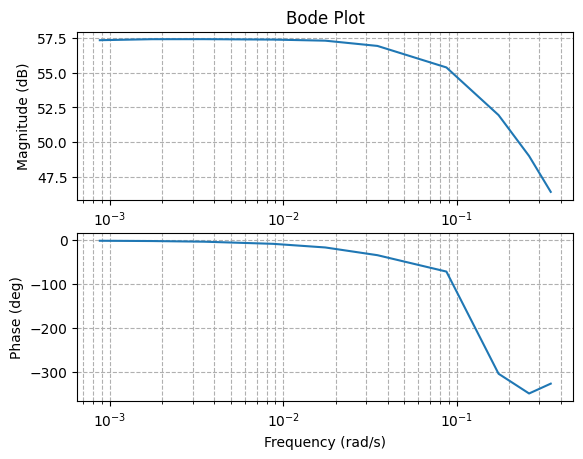

In [1460]:
fig, ax = plt.pyplot.subplots(nrows=2, ncols=1)
ax[0].title.set_text('Bode Plot')
ax[0].set_xscale('log')
ax[0].grid(True, which="both", ls="--")
ax[0].plot(frequencies_rad, mag)
ax[0].set_xlabel('Frequency (rad/s)')
ax[0].set_ylabel('Magnitude (dB)')

ax[1].set_xscale('log')
ax[1].grid(True, which="both", ls="--")
ax[1].plot(frequencies_rad, phase1)
ax[1].set_xlabel('Frequency (rad/s)')
ax[1].set_ylabel('Phase (deg)')